In [1]:
from dateutil.relativedelta import relativedelta
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pageviewapi
from datetime import datetime as dt
import requests
from attrdict import AttrDict
import statistics
import matplotlib.pyplot as plt
import datetime
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import sklearn.metrics as metrics
import scipy.stats

### visualize the number of views for 400 days

In [2]:
__version__   = "0.4.0"
PROJECT_URL   = "https://github.com/Commonists/pageview-api"
UA            = "Python pageview-api client v{version} <{url}>"
USER_AGENT    = {'User-Agent': UA.format(url=PROJECT_URL, version=__version__)}
API_BASE_URL  = "https://wikimedia.org/api/rest_v1/metrics"
PA_ENDPOINT   = "pageviews/per-article"
PA_ARGS       = "{project}/{access}/{agent}/{page}/{granularity}/{start}/{end}"

def per_article(project, page, start, end,access='all-access', agent='all-agents', granularity='daily'):

    args = PA_ARGS.format(project=project,page=page,start=start,end=end,access=access,agent=agent,granularity=granularity)
    return __api__(PA_ENDPOINT, args)

def __api__(end_point, args, api_url=API_BASE_URL):
    
    url = "/".join([api_url, end_point, args])
    response = requests.get(url, headers=USER_AGENT)
    
    if response.status_code == 200:
        return response.json()
    
    elif response.status_code == 404:
        print("error404:  "+args)
    
    #elif response.status_code == 429:
        #raise ThrottlingException
    
    else:
        response.raise_for_status()

In [3]:
#Two Examples
names=["2016_Kumamoto_earthquakes","Alan_Rickman"]
start_dates=["2016-04-15","2016-01-14"]

date_list =list(range(0, 400, 1))
df_decay=pd.DataFrame(index=date_list)

for name,date_str in zip(names,start_dates):
    
    start_date=datetime.datetime.strptime(date_str, '%Y-%m-%d')#イベント発生日
    last_date=start_date+datetime.timedelta(days=399)

    response=per_article('en.wikipedia', name, start_date.strftime('%Y%m%d'), last_date.strftime('%Y%m%d'), access='all-access', agent='user', granularity='daily')

    if type(response)==dict:

        if len(response['items'])==400:

            page_view_lis=[]
            for i in range(len(response['items'])):
                page_view_lis.append(response['items'][i]["views"])

            df_decay[name]=page_view_lis

        else:#APIの取得に漏れがある
            print(f"not_enough:{name}")

    else:#responseなし
        print(f"not_response:{name}")

    df_decay[name]=page_view_lis
#df_decay

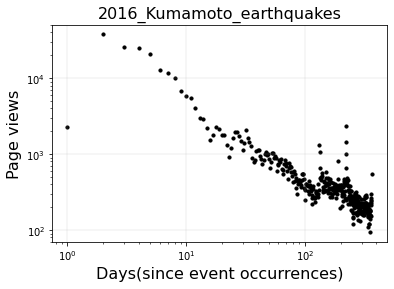

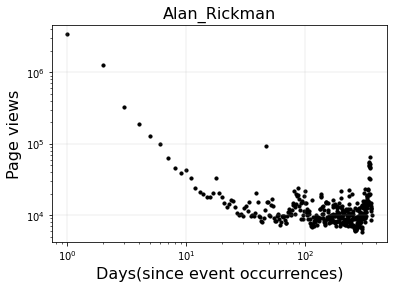

In [4]:
names=["2016_Kumamoto_earthquakes","Alan_Rickman"]
for name in names:
    df=df_decay[name][:365]
    x=np.linspace(1,365,365)#x
    y=df.values#y
    
    fig=plt.figure()
    
    #log-log plot
    plt.xscale('log')
    plt.yscale('log')
    
    plt.scatter(x, y, s=10, c="black")
    
    plt.xlabel("Days(since event occurrences)",size=16)
    plt.ylabel("Page views",size=16)
    
    #grid
    plt.grid(linewidth=0.2)
    
    #title
    plt.title(f'{name}', loc='center',size=16)
    
    #グラフの保存
    #fig.savefig(f"C:/Users/naoki/OneDrive/デスクトップ/{file}.eps")
    
    #グラフ描画
    plt.show()

### Fitting with same function

In [5]:
def beki(x, A, a):
    return np.log10( A * (x**(-a)) )

def exp(x, A, a):
    return np.log10( A * np.exp(-a*x))

def biexp(x, A, a, B, b):
    return np.log10( A * np.exp(-a*x) + B * np.exp(-b*x) )

def stretch(x, a, b, c):
    return np.log10( np.exp( -(x/a)**( b*x**(-c)) ) )

def shiftbeki(x, a, b, c):
    return np.log10( a * (x**(-b)) + c )

def expbeki(x, A, a, B, b):
    return np.log10( A *np.exp(-a*x)+ B*(x**(-b)) )

In [6]:
def beki_nolog(x, A, a):
    return A * (x**(-a))

def exp_nolog(x, A, a):
    return A * np.exp(-a*x)

def biexp_nolog(x, A, a, B, b):
    return A * np.exp(-a*x) + B * np.exp(-b*x)

def stretch_nolog(x, a, b, c):
    return np.exp( -(x/a)**( b*x**(-c)) )

def shiftbeki_nolog(x, a, b, c):
    return a * (x**(-b)) + c 

def expbeki_nolog(x, A, a, B, b):
    return A *np.exp(-a*x)+ B*(x**(-b))

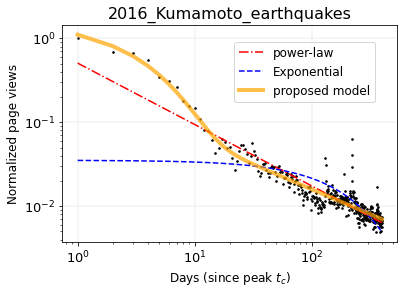

beta:0.2902083860458369,alpha:0.594791119376134


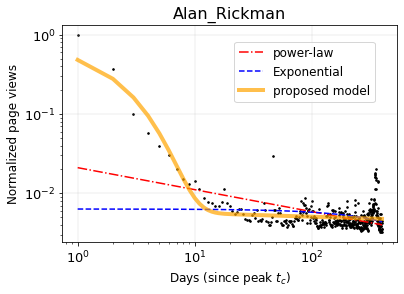

beta:0.55769350349532,alpha:0.0452113256474744


In [7]:
names=["2016_Kumamoto_earthquakes","Alan_Rickman"]

for name in names:
    
    df=df_decay[name]
    df_fromax=df[df.idxmax():]
    minimum = np.min(df_fromax.values[np.nonzero(df_fromax.values)])
    df=df_fromax+minimum
    df_norm=df/df.max()
    df_norm.reset_index(drop=True, inplace=True)

    y_analysis=np.log10(df_norm)
    x_analysis = np.linspace(1,len(y_analysis),len(y_analysis))
    
    popt_beki, _      = optimize.curve_fit(beki, x_analysis, y_analysis, bounds=((0,0),(np.inf,np.inf)) )
    popt_exp, _       = optimize.curve_fit(exp, x_analysis, y_analysis, bounds=((0,0),(np.inf,np.inf)) )
    popt_biexp, _     = optimize.curve_fit(biexp, x_analysis, y_analysis, bounds=((0,0,0,0),(np.inf,np.inf,np.inf,np.inf)))
    popt_stretch, _   = optimize.curve_fit(stretch, x_analysis, y_analysis, bounds=((0,0,0),(np.inf,np.inf,np.inf)))
    popt_shiftbeki, _ = optimize.curve_fit(shiftbeki, x_analysis, y_analysis, bounds=((0,0,0),(np.inf,np.inf,np.inf)))
    popt_expbeki, _ = optimize.curve_fit(expbeki, x_analysis, y_analysis, bounds=((0,0,0,0),(np.inf,np.inf,np.inf,np.inf)))

    fig = plt.figure()
    plt.scatter(x_analysis,df_norm.values,marker='.',s=10, c="black")
    plt.grid(linewidth=0.2)
    plt.title(f'{name}', loc='center',size=16)
    
    plt.plot(x_analysis,beki_nolog(x_analysis,popt_beki[0],popt_beki[1]),linestyle = "dashdot", label = "power-law", color = "red",alpha = 1)
    plt.plot(x_analysis,exp_nolog(x_analysis,popt_exp[0],popt_exp[1]),linestyle = "dashed", label = "Exponential", color = "blue",alpha = 1)
    plt.plot(x_analysis,expbeki_nolog(x_analysis,popt_expbeki[0],popt_expbeki[1],popt_expbeki[2],popt_expbeki[3]),linestyle = "solid", label = "proposed model", linewidth = 4, color = "orange",alpha = 0.7)
    
    plt.legend(bbox_to_anchor=(0.95, 0.95), loc='upper right', borderaxespad=0.5, fontsize=12)
    plt.xscale('log')
    plt.yscale("log")
    plt.xlabel(r"Days (since peak $t_{c}$)",size=12)
    plt.ylabel(r"Normalized page views",size=12)
    plt.tick_params(axis='y', which='major', labelsize=13)
    plt.tick_params(axis='x', which='major', labelsize=13)
    
    #グラフの保存
    #fig.savefig(f"C:/Users/naoki/OneDrive/デスクトップ/figure_work/3fit.eps")
    
    #グラフ描画
    plt.show()
    print(f"beta:{popt_expbeki[1]},alpha:{popt_expbeki[3]}")

### Model

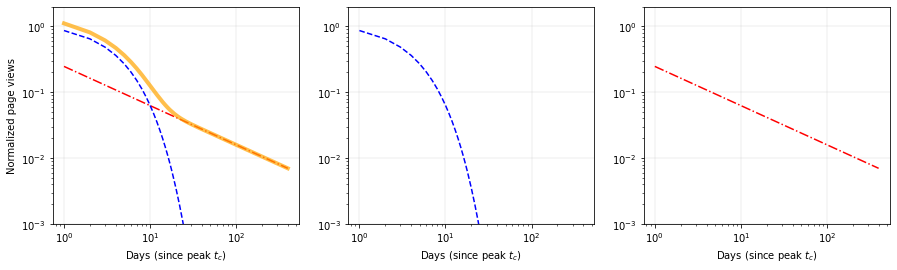

In [8]:
#MemorySwitchingPoint(example)
file="disaster"
name="2016_Kumamoto_earthquakes"

df=df_decay[name]
df_fromax=df[df.idxmax():]
minimum = np.min(df_fromax.values[np.nonzero(df_fromax.values)])
df=df_fromax+minimum
df_norm=df/df.max()
df_norm.reset_index(drop=True, inplace=True)

y_analysis=np.log10(df_norm)
x_analysis = np.linspace(1,len(y_analysis),len(y_analysis))

popt_expbeki, _ = optimize.curve_fit(expbeki, x_analysis, y_analysis, bounds=((0,0,0,0),(np.inf,np.inf,np.inf,np.inf)))

fig=plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.grid(linewidth=0.2)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(0.001,2)
ax1.plot(x_analysis,beki_nolog(x_analysis,popt_expbeki[2],popt_expbeki[3]),linestyle = "dashdot", label = "power-law", color = "red",alpha = 1)
ax1.plot(x_analysis,exp_nolog(x_analysis,popt_expbeki[0],popt_expbeki[1]),linestyle = "dashed", label = "Exponential", color = "blue",alpha = 1)
ax1.plot(x_analysis,expbeki_nolog(x_analysis,popt_expbeki[0],popt_expbeki[1],popt_expbeki[2],popt_expbeki[3]),linestyle = "solid", label = "proposed model", linewidth = 4, color = "orange",alpha = 0.7)
ax1.set_xlabel(r"Days (since peak $t_{c}$)",size=10)
ax1.set_ylabel(r"Normalized page views",size=10)

ax2.grid(linewidth=0.2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(0.001,2)
ax2.plot(x_analysis,exp_nolog(x_analysis,popt_expbeki[0],popt_expbeki[1]),linestyle = "dashed", label = "Exponential", color = "blue",alpha = 1)
ax2.set_xlabel(r"Days (since peak $t_{c}$)",size=10)

ax3.grid(linewidth=0.2)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim(0.001,2)
ax3.plot(x_analysis,beki_nolog(x_analysis,popt_expbeki[2],popt_expbeki[3]),linestyle = "dashdot", label = "power-law", color = "red",alpha = 1)
ax3.set_xlabel(r"Days (since peak $t_{c}$)",size=10)

plt.show()

### MemorySwitchingPoint

<ipython-input-9-fb64c4355cc0>:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


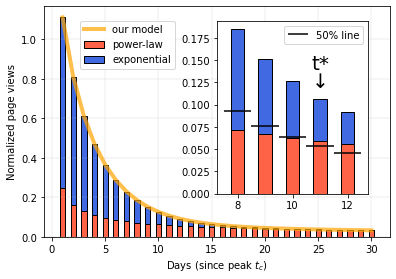

In [9]:
#####Big Figure######
left = x_analysis.tolist()[:30]
pop = np.array([beki_nolog(x_analysis,popt_expbeki[2],popt_expbeki[3]).tolist()[:30],exp_nolog(x_analysis,popt_expbeki[0],popt_expbeki[1]).tolist()[:30]])

#Stacked graph
fig = plt.figure()
axes1 = fig.add_axes([0.1, 0.1, 0.8, 0.8]) #size
color_lis=["tomato","royalblue"]#色指定
for i,color in zip(range(pop.shape[0]),color_lis):
    axes1.bar(left, pop[i],bottom = np.sum(pop[:i], axis = 0),width=0.5, edgecolor='k', linewidth=1,color=color)

#curve
axes1.plot(x_analysis[:30],expbeki_nolog(x_analysis[:30],popt_expbeki[0],popt_expbeki[1],popt_expbeki[2],popt_expbeki[3])[:30],linestyle = "solid", label = "proposed model", linewidth = 4, color = "orange",alpha = 0.7)
axes1.legend(["our model","power-law", "exponential"], loc='upper left',bbox_to_anchor=(0.09, 0.96))
#axes1.set_yscale("log")
axes1.grid(linewidth=0.2)
plt.xlabel(r"Days (since peak $t_{c}$)",size=10)
plt.ylabel("Normalized page views",size=10)

#####Small Figure######
left2 = x_analysis.tolist()[7:12]
pop2 = np.array([beki_nolog(x_analysis,popt_expbeki[2],popt_expbeki[3]).tolist()[7:12],exp_nolog(x_analysis,popt_expbeki[0],popt_expbeki[1]).tolist()[7:12]])
axes2 = fig.add_axes([0.5, 0.25, 0.35, 0.6]) 

#Stacked graph
color_lis=["tomato","royalblue"]
for i,color in zip(range(pop2.shape[0]),color_lis):#shapeでサイズを知れる
    axes2.bar(left2, pop2[i],bottom = np.sum(pop2[:i], axis = 0),width=0.5, edgecolor='k', linewidth=1,color=color)

#Auxiliary characters
axes2.text(10.7,0.14,"t*", fontsize=20)
axes2.text(10.7,0.12,"↓", fontsize=20)

#Auxiliary line
axes2.hlines([(pop2[0][0]+pop2[1][0])/2], 7.5, 8.5, "black", linestyles='solid', label = "50% line")
axes2.hlines([(pop2[0][1]+pop2[1][1])/2], 8.5, 9.5, "black", linestyles='solid')
axes2.hlines([(pop2[0][2]+pop2[1][2])/2], 9.5, 10.5, "black", linestyles='solid')
axes2.hlines([(pop2[0][3]+pop2[1][3])/2], 10.5, 11.5, "black", linestyles='solid')
axes2.hlines([(pop2[0][4]+pop2[1][4])/2], 11.5, 12.5, "black", linestyles='solid')
axes2.legend()

#グラフの保存
#fig.savefig(f"C:/Users/naoki/OneDrive/デスクトップ/figure_work/memorypoint.eps")

fig.show()